In [19]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from dataset import SatelliteDataset
from UNet import UNet

MODEL = 'UNet'
EPOCH = 1000
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
IMAGE_SIZE = (400, 400)
VAL_SPILIT = 0.1
TEST_SPLIT = 0.1
DEVICE = 'cuda'

# Dataset

In [20]:
noise_dataset = SatelliteDataset('Train', (IMAGE_SIZE), transform=True, add_noise=True)
clean_dataset = SatelliteDataset('Train', (IMAGE_SIZE), transform=True, add_noise=False)

indices = list(range(len(noise_dataset)))
random.shuffle(indices)

train_size = int((1 - VAL_SPILIT - TEST_SPLIT) * len(noise_dataset))
val_size = int(VAL_SPILIT * len(noise_dataset))
test_size = len(noise_dataset) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_dataset = Subset(noise_dataset, train_indices)
val_dataset = Subset(clean_dataset, val_indices)
test_dataset = Subset(clean_dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [21]:
if MODEL == 'UNet':
    model = UNet(in_channels=3, out_channels=1, init_features=32).to(DEVICE)
elif MODEL == 'ResNet':
    pass

state_dict = torch.load('checkpoints/UNet_460.pth')
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

# Vis

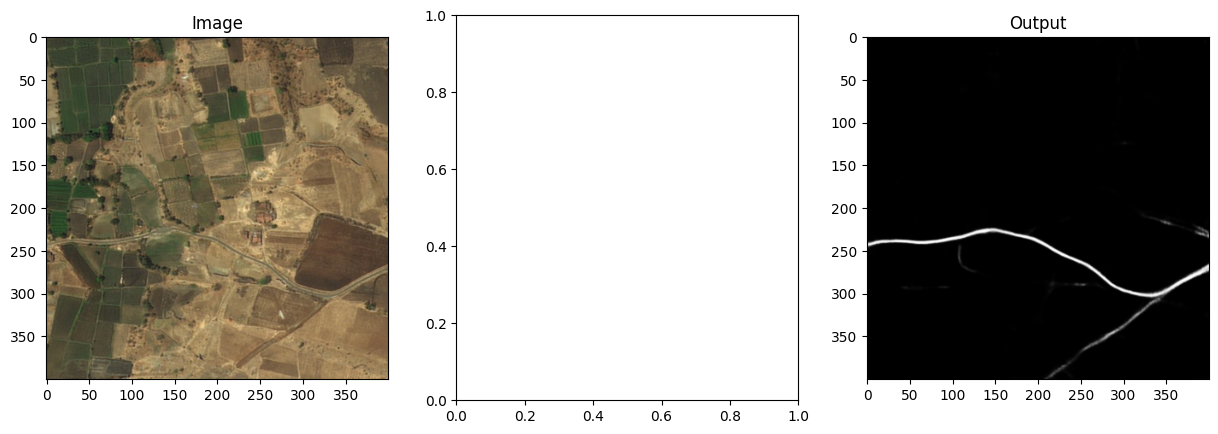

In [35]:
try:
    test_iterator
except NameError:
    test_iterator = iter(test_dataloader)
def show_next_sample(model):
    images, labels = next(test_iterator)
    images = images.to(DEVICE)
    # labels = labels.to(DEVICE)
    outputs = model(images)

    image = images.cpu().numpy()[0]
    # label = labels.cpu().numpy()[0]
    output = outputs.cpu().numpy()[0]

    image = np.transpose(image, (1, 2, 0))
    # label = np.transpose(label, (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = image * std + mean
    image = np.clip(image, 0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Image')

    # axs[1].imshow(label, cmap='gray')
    # axs[1].set_title('Label')

    axs[2].imshow(output, cmap='gray')
    axs[2].set_title('Output')

    plt.show()

show_next_sample(model)